In [1]:
from dataset import *
from train import *


In [2]:
import os
import pandas as pd

import torch
import torch.optim as optim

In [3]:
# Set parameters
EuroSat_Type = 'ALL'    
target_country = 'Magyarország'

lr = 0.01               # learn_rate
milestones = [50,75,90] # multistep scheduler
epochs = 3            # no of epochs

output_path = "./" + target_country

## Download data

In [4]:
# raw data
if EuroSat_Type == 'RGB':
  data_folder = '/content/sample_data/'
  #root = os.path.join(data_folder, '2750/')
  root = '2750/'
  download_ON = os.path.exists(root)

  if not download_ON:
    # This can be long...
    #os.chdir(data_folder)
    os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip') #Just RGB Bands
    !unzip EuroSAT.zip
    download_ON = True
elif EuroSat_Type == 'ALL':
    root = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif/'
    download_ON = os.path.exists(root)
    if not download_ON:
      os.system('wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip') #All bands
      !unzip EuroSATallBands.zip
      download_ON = True
    
data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'tif')

In [5]:
# Metadata
geo_df = pd.read_csv("metadata.csv")
geo_dict = geo_df.to_dict()
countries = list(set(geo_dict["country"].values()))
id_countries = dict.fromkeys(countries)
for k in id_countries.keys():
    id_countries[k] = [v for (i, v) in enumerate(geo_dict["id"]) if geo_dict["country"][i] == k]

In [6]:
# source - target split
id_target = id_countries[target_country]
id_train = random.sample(id_target, 320)
id_test = list(set(id_target) - set(id_train))[0:160]

loader_target_train = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_train), 
                                                  batch_size= 16, shuffle=False, num_workers=0)
loader_target_test = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_test), 
                                                  batch_size= 16, shuffle=False, num_workers=0)

id_random_source = random.sample(list(geo_dict["id"].values()),
                                len(loader_target_train.dataset))
loader_random_source = torch.utils.data.DataLoader(torch.utils.data.Subset(data, id_random_source), 
                                                  batch_size= 16, shuffle=False, num_workers=0)

## Train

In [8]:
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
print("pytorch version", torch.__version__)
criteria = torch.nn.CrossEntropyLoss()
net = Load_model()
if torch.cuda.is_available():
    net=net.cuda()
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

pytorch version 1.8.0
Model Loaded


In [9]:
train_loader, val_loader, test_loader =Load_data(root)

Iteration Number 0 1.1221911907196045 seconds
Train (epoch 1/3) [0/20 (0%)]	Loss: 3.421485	Accuracy: 0.0	Learning Rate:0.01


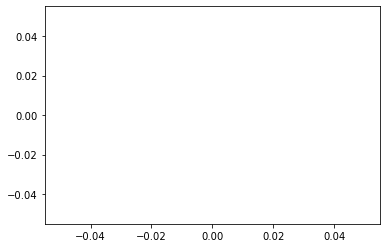

validation accuracy : 0.84375


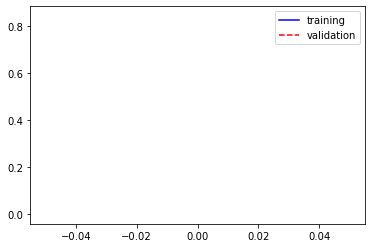

e= 2 20.05058717727661 seconds
e= 3 38.00026607513428 seconds


In [10]:
net = train(net, loader_target_train, loader_target_test, criteria, optimizer, epochs, scheduler)

In [15]:
torch.save(net.state_dict(), output_path + "target_train.pt" )

Iteration Number 0 1.4195923805236816 seconds
Train (epoch 1/3) [0/20 (0%)]	Loss: 2.643484	Accuracy: 0.0625	Learning Rate:0.01


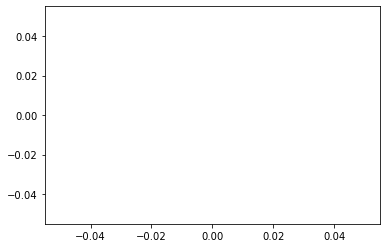

validation accuracy : 0.0125


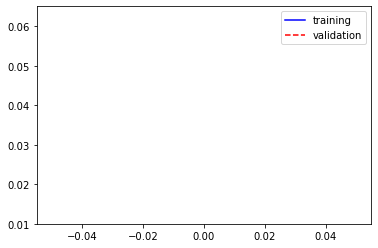

e= 2 19.683011293411255 seconds
e= 3 36.96199035644531 seconds


In [11]:
net_random = Load_model()
net_random = train(net_random, loader_random_source, loader_target_test, criteria, optimizer, epochs, scheduler)
torch.save(net_random.state_dict(), output_path + "random_source" )